# Course 4: Feature Engineering with Pyspark

Since most of the theorical aspect is defined in previous course. This course notebook will contain mostly code and the comments will explain how it would do to perform social bot detection problem.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Spark').config("spark.driver.memory", "10g").getOrCreate()
sc = spark.sparkContext

23/04/04 21:26:28 WARN Utils: Your hostname, Mufins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
23/04/04 21:26:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 21:26:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
user_df = spark.read.json('user.json')

In [3]:
# DataFrame.count() for row count
user_df.count()

1000000

In [4]:
# DataFrame.columns for a list of columns
user_df.columns

['created_at',
 'description',
 'entities',
 'id',
 'location',
 'name',
 'pinned_tweet_id',
 'profile_image_url',
 'protected',
 'public_metrics',
 'url',
 'username',
 'verified',
 'withheld']

In [5]:
len(user_df.columns)

14

In [6]:
# DataFrame.dtypes creates a list of columns and their data types tuples
user_df.dtypes

[('created_at', 'string'),
 ('description', 'string'),
 ('entities',
  'struct<description:struct<cashtags:array<struct<end:bigint,start:bigint,tag:string>>,hashtags:array<struct<end:bigint,start:bigint,tag:string>>,mentions:array<struct<end:bigint,start:bigint,username:string>>,urls:array<struct<display_url:string,end:bigint,expanded_url:string,start:bigint,url:string>>>,url:struct<urls:array<struct<display_url:string,end:bigint,expanded_url:string,start:bigint,url:string>>>>'),
 ('id', 'string'),
 ('location', 'string'),
 ('name', 'string'),
 ('pinned_tweet_id', 'bigint'),
 ('profile_image_url', 'string'),
 ('protected', 'boolean'),
 ('public_metrics',
  'struct<followers_count:bigint,following_count:bigint,listed_count:bigint,tweet_count:bigint>'),
 ('url', 'string'),
 ('username', 'string'),
 ('verified', 'boolean'),
 ('withheld', 'struct<country_codes:array<string>>')]

In [7]:
# Display summary statistics
user_df.describe().show()

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|summary|          created_at|         description|                 id|            location|                name|     pinned_tweet_id|   profile_image_url|               url|       username|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+---------------+
|  count|             1000000|             1000000|            1000000|              708458|             1000000|              389865|             1000000|           1000000|        1000000|
|   mean|                null|                 NaN|               null|                 NaN|                 NaN|1.332168970129807...|                null|              null|       Infinity|
| stddev|                null|               

In [8]:
# For semi-structured data, printSchema() provides a more flexible way to visualize
# the schema
user_df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- description: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- description: struct (nullable = true)
 |    |    |-- cashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- tag: string (nullable = true)
 |    |    |-- hashtags: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- tag: string (nullable = true)
 |    |    |-- mentions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- username: string (nullable = true)
 |    |

In [9]:
# Aggregation
user_df.agg({
    'public_metrics.followers_count': 'mean'
}).collect()

[Row(avg(public_metrics.followers_count AS followers_count)=41230.145237)]

In [10]:
# Get covariance of 2 attributes
user_df.cov('public_metrics.followers_count', 'public_metrics.following_count')

502526698.4296811

In [11]:
# Sample 5% of the Pyspark DataFrame and count rows
# 3 arguments: with_replacement, proportion, random seed
user_df.sample(False, 0.05, 42).count()

50162

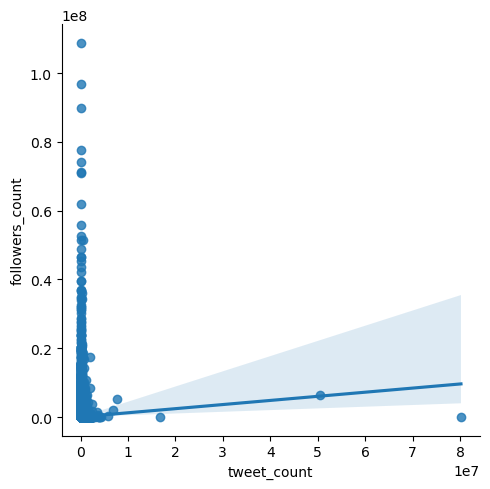

In [12]:
# Prepping for plotting a distribution

# Import the visualization library
import seaborn as sns

# Sample the dataframe
sample_df = user_df.select([
    'public_metrics.tweet_count',
    'public_metrics.followers_count'
]).sample(False, 0.5, 42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.lmplot(x='tweet_count', y='followers_count', data=pandas_df)

In [13]:
# Standardization example
mean_followers_count = user_df.agg({
    'public_metrics.followers_count': 'mean'
}).collect()[0][0]
stddev_followers_count = user_df.agg({
    'public_metrics.followers_count': 'stddev'
}).collect()[0][0]

user_df = user_df.withColumn(
    "ztrans_followers_count",
    (user_df["public_metrics.followers_count"] - mean_followers_count) / stddev_followers_count
)

In [14]:
# Confirm that the new column has mean of 0
user_df.agg({"ztrans_followers_count": "mean"}).collect()

[Row(avg(ztrans_followers_count)=1.3261969633582283e-14)]

In [15]:
# and standard deviation of 1
user_df.agg({"ztrans_followers_count": "stddev"}).collect()

[Row(stddev(ztrans_followers_count)=0.9999999999999997)]

In [16]:
# Log scaling
from pyspark.sql.functions import log

user_df = user_df.withColumn('log_followers_count', log(user_df['public_metrics.followers_count']))
user_df.select(['log_followers_count']).collect()[:10]

[Row(log_followers_count=8.897819009510757),
 Row(log_followers_count=4.812184355372417),
 Row(log_followers_count=1.0986122886681096),
 Row(log_followers_count=5.857933154483459),
 Row(log_followers_count=5.480638923341991),
 Row(log_followers_count=0.0),
 Row(log_followers_count=12.381092610462607),
 Row(log_followers_count=5.081404364984463),
 Row(log_followers_count=9.239802082125802),
 Row(log_followers_count=5.37989735354046)]

In [17]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col.split('.')[-1]
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
    return df

In [18]:
user_df = min_max_scaler(user_df, cols_to_scale=[
    'public_metrics.following_count'
])
user_df[['public_metrics.following_count', 'scaled_following_count']].show()

+---------------+----------------------+
|following_count|scaled_following_count|
+---------------+----------------------+
|            215|  5.166988662184925E-5|
|           1090|  2.619543089200729...|
|             62|  1.490015335141699...|
|            577|  1.386675561898001E-4|
|            297|  7.137654105436849E-5|
|            378|  9.084287043283263E-5|
|            293|  7.041524083814805E-5|
|            278|  6.681036502732135E-5|
|           2166|  5.205440670833743E-4|
|            233|  5.599573759484128E-5|
|            136|  3.268420735149533...|
|            154|  3.701005832448737E-5|
|            393|  9.444774624365933E-5|
|            241|  5.791833802728218E-5|
|           1302|  3.129032203797568E-4|
|            990|  2.379218035145616...|
|           1206|  2.898320151904660...|
|           1688|  4.056686912450304E-4|
|           4739|  0.001138900431167...|
|            587|  1.410708067303512E-4|
+---------------+----------------------+
only showing top

In [19]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [20]:
len(user_df.columns)

17

In [21]:
user_df = column_dropper(user_df, 0.3)
len(user_df.columns)

14

In [26]:
label_df = spark.read.csv('label.csv', header=True, inferSchema=True)

# Specify join condition
cond = label_df['id'] == user_df['id']
# Join 2 hdf onto df
full_df = user_df.join(label_df, on=cond, how='left')
full_df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- description: string (nullable = true)
 |-- id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- profile_image_url: string (nullable = true)
 |-- protected: boolean (nullable = true)
 |-- public_metrics: struct (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following_count: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- tweet_count: long (nullable = true)
 |-- url: string (nullable = true)
 |-- username: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- ztrans_followers_count: double (nullable = true)
 |-- log_followers_count: double (nullable = true)
 |-- scaled_following_count: double (nullable = true)
 |-- id: string (nullable = true)
 |-- label: string (nullable = true)

